In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "cassandra"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 36
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,0,1,0.839080,0.663636,0.741117,0.830101,0.748601,0.863864,0.844444,base
1,cassandra,0,2,0.731707,0.612245,0.666667,0.783013,0.692959,0.782418,0.784314,base
2,cassandra,0,3,0.781609,0.629630,0.697436,0.800272,0.706822,0.831402,0.793478,base
3,cassandra,0,4,0.686567,0.522727,0.593548,0.743506,0.651702,0.674627,0.812500,base
4,cassandra,0,5,0.742424,0.532609,0.620253,0.765046,0.669905,0.761462,0.842593,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.658824,0.682927,0.670659,0.776664,0.717697,0.711780,0.754237,ecoselekt
1,cassandra,15,17,0.678571,0.740260,0.708075,0.787615,0.760108,0.669825,0.780488,ecoselekt
2,cassandra,15,18,0.714286,0.802469,0.755814,0.856987,0.791922,0.825885,0.781513,ecoselekt
3,cassandra,15,19,0.703704,0.678571,0.690909,0.813937,0.733606,0.784243,0.793103,ecoselekt
4,cassandra,15,20,0.739130,0.772727,0.755556,0.863354,0.817880,0.752668,0.865672,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.740260,0.695122,0.716981,0.867559,0.759806,0.831972,0.830508,best
1,cassandra,15,17,0.763158,0.753247,0.758170,0.867173,0.801882,0.817752,0.853659,best
2,cassandra,15,18,0.837500,0.827160,0.832298,0.930335,0.858370,0.911077,0.890756,best
3,cassandra,15,19,0.813333,0.726190,0.767296,0.924826,0.799091,0.908818,0.879310,best
4,cassandra,15,20,0.818182,0.818182,0.818182,0.934362,0.863083,0.858428,0.910448,best


(420, 11)


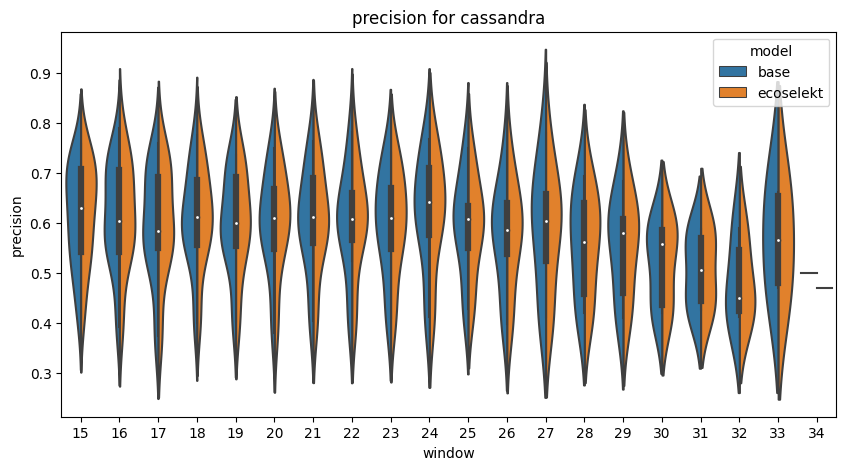

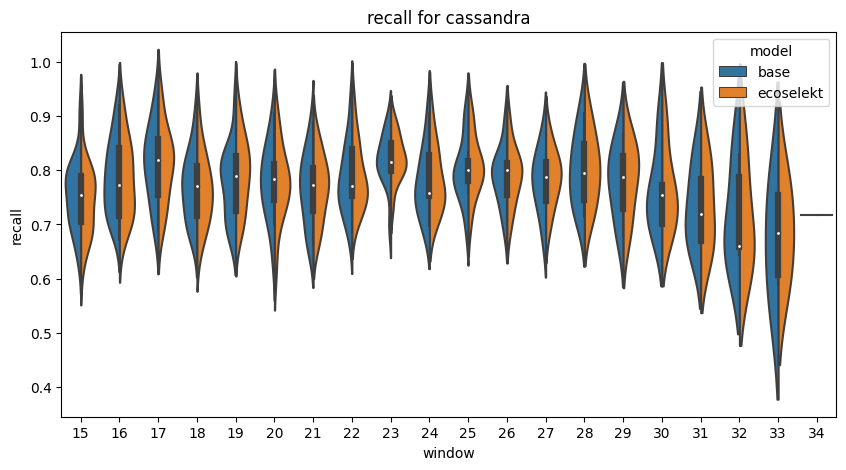

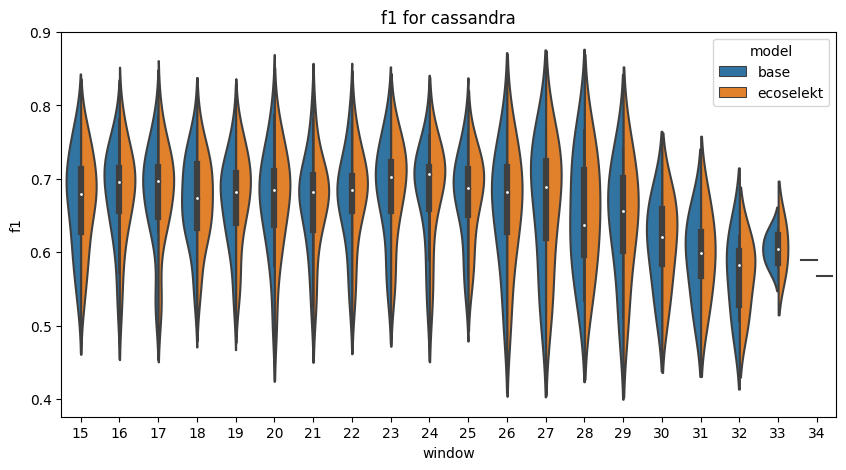

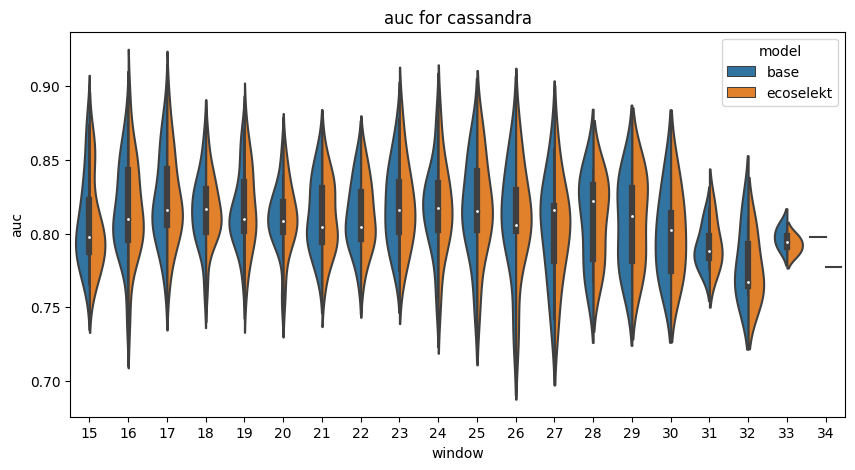

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


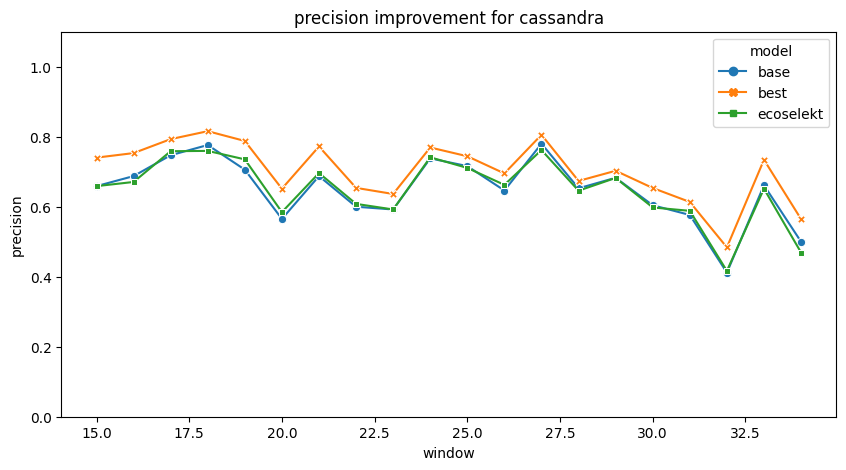

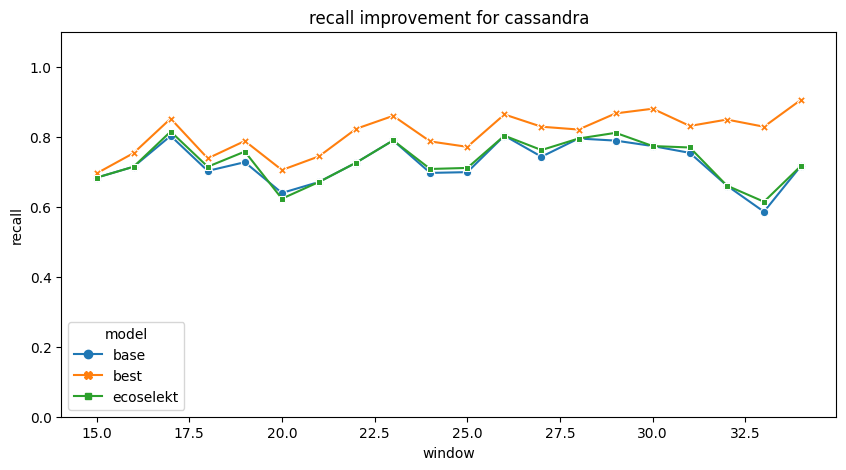

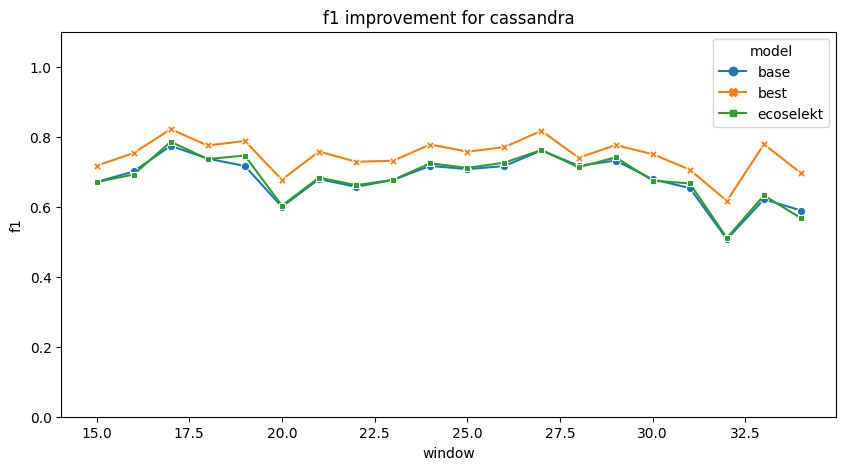

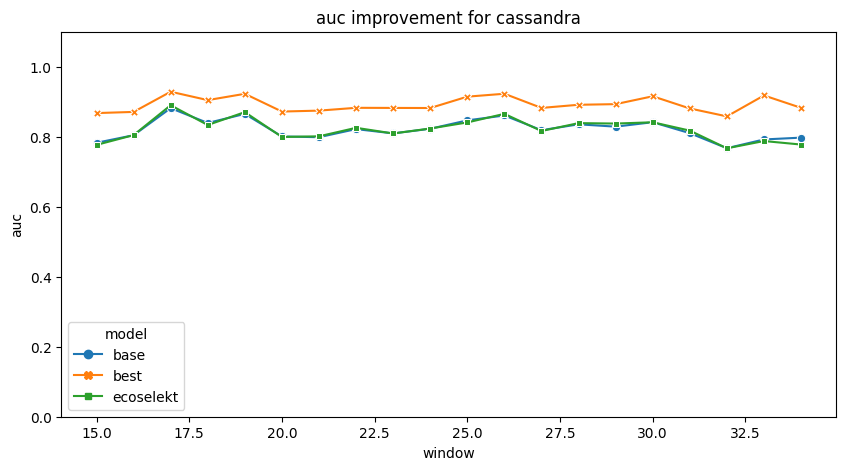

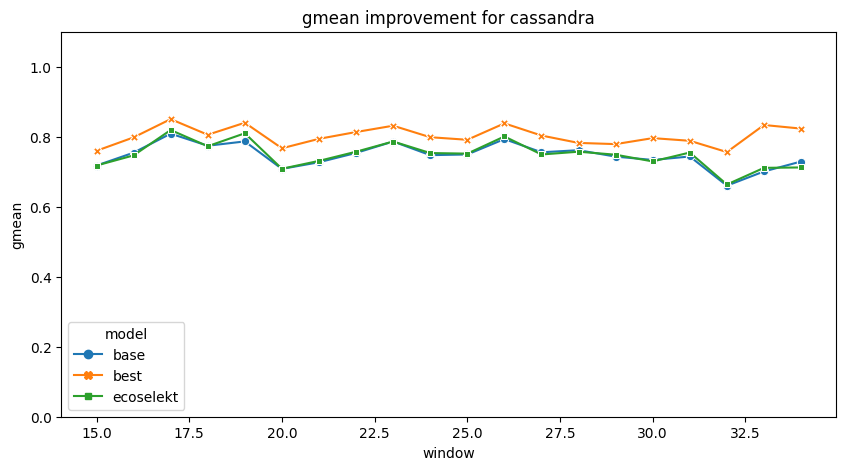

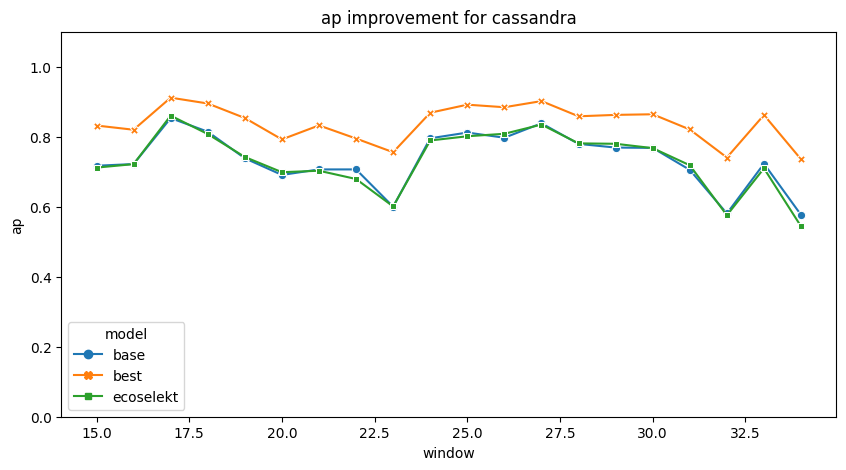

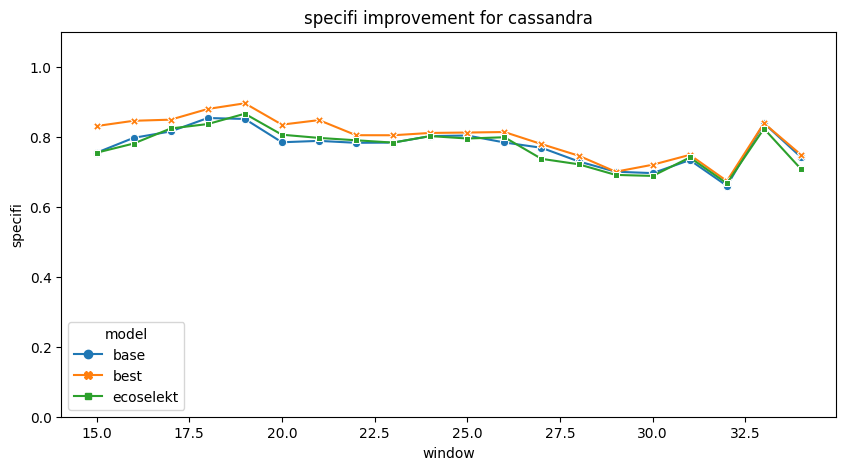

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

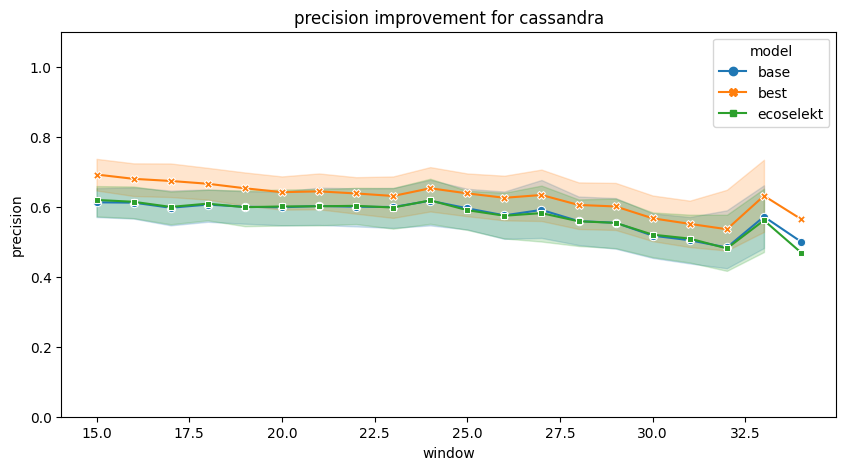

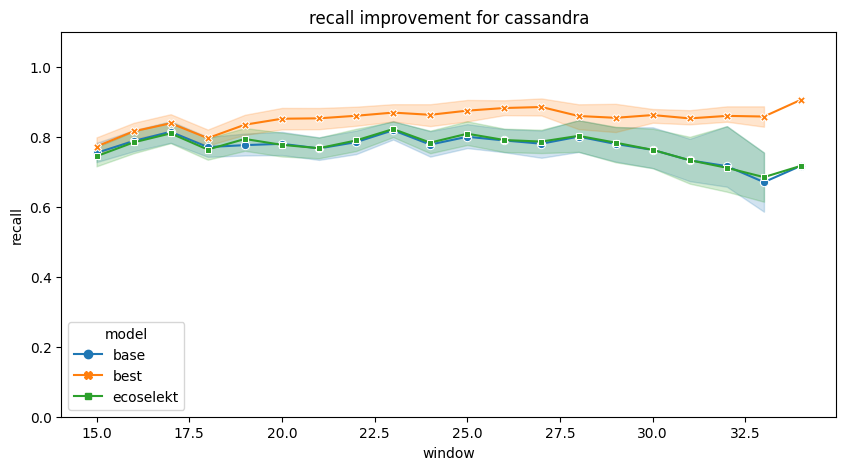

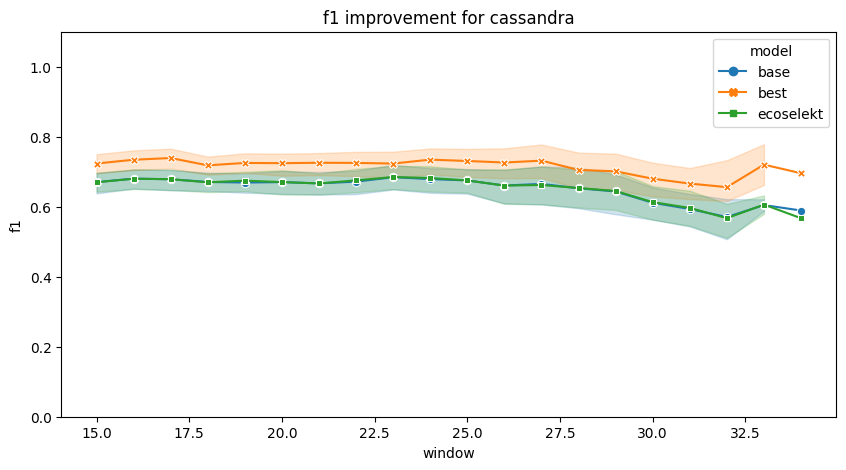

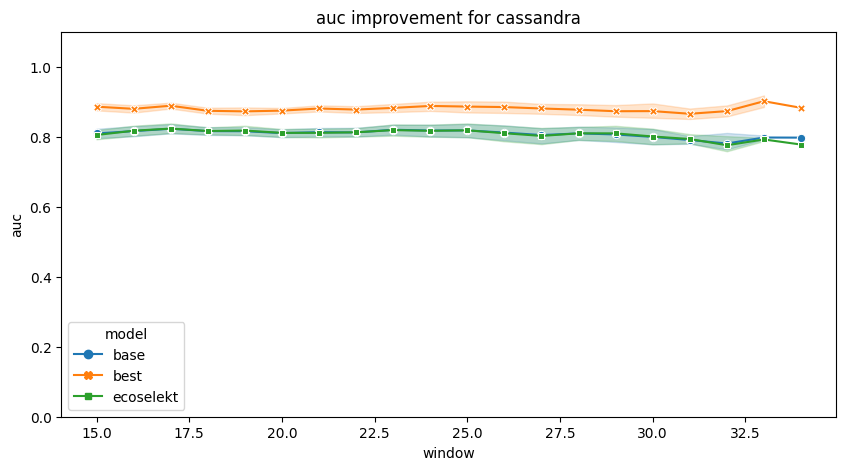

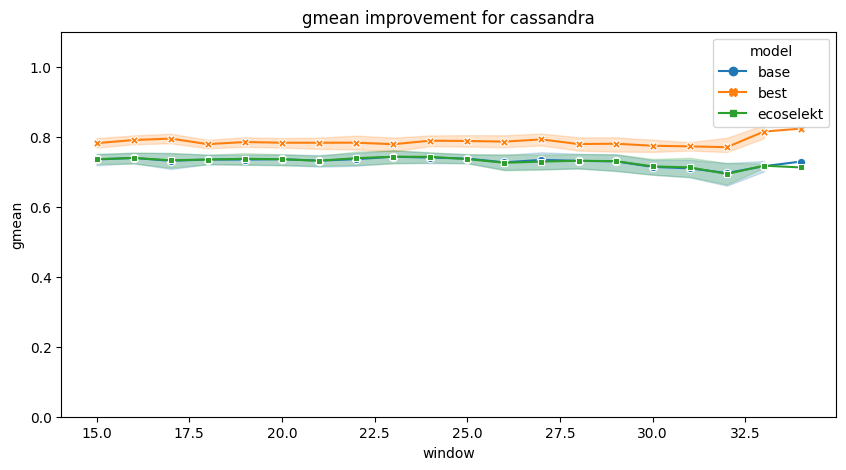

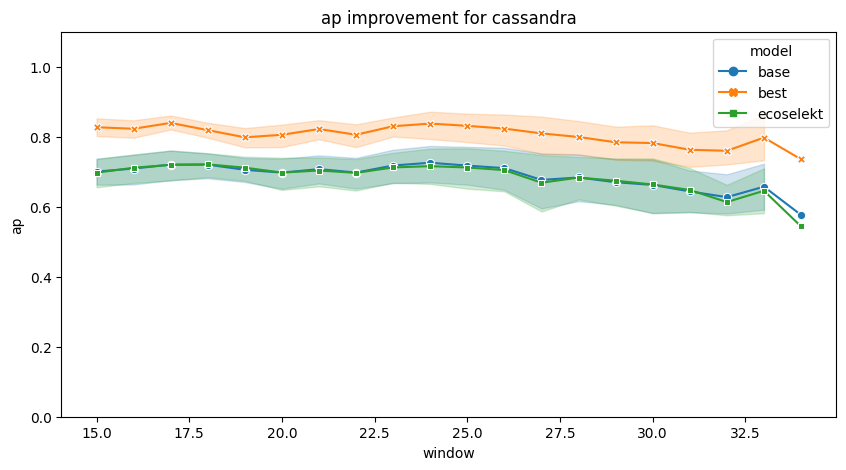

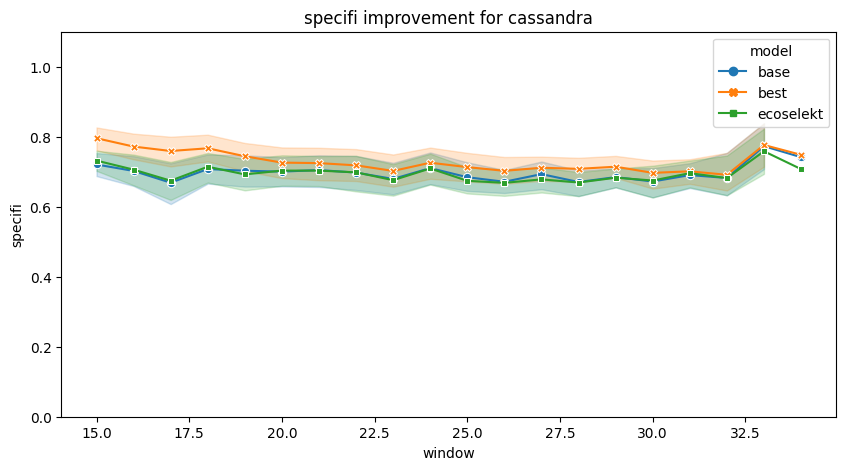

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.7285060882568359
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.02841686417486375
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(42000, 4)


,commit_id,window,test_split,model_version
0,89e250b8b347876a5c9f74e738e182b66495d61b,15,16,15
1,593807007415b28ffb128f408c44cac2023930dc,15,16,15
2,49cb6901b269ff3ea2b5e388aec2c8fcb9879194,15,16,15
3,a67f77922a5aba36540abd4526adf4ded1d6e8c7,15,16,15
4,0467c19d9df454e40710cf8fa0ac9703360b4528,15,16,9


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(42000, 4)


,commit_id,window,test_split,model_version
0,00748405bc374ee8f5ade4891a6a1445df072344,15,16,15
1,018e82b5eff17b50301a01069664ef37a4ae142f,15,16,15
2,01bc564bb2e89684b445f217a83c39f32113560a,15,16,15
3,01d81d27651c9608fa1344ea1ca769ea8ec4e4d6,15,16,15
4,03b4c2794c4c0f5e11ec9a24b52b523d8746fbb5,15,16,15


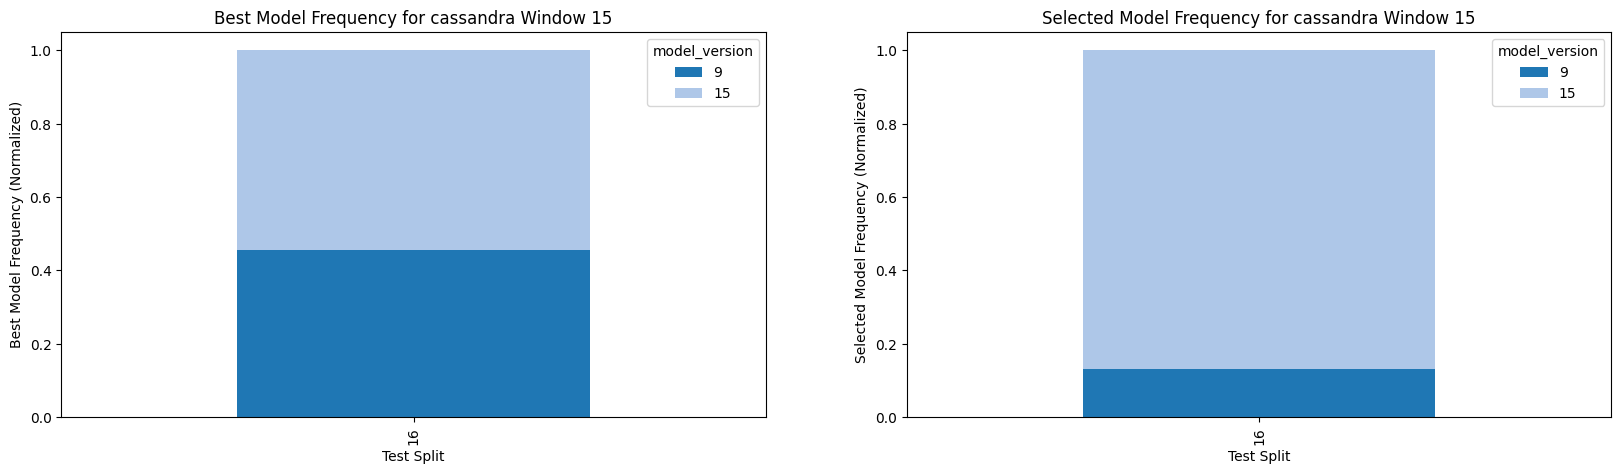

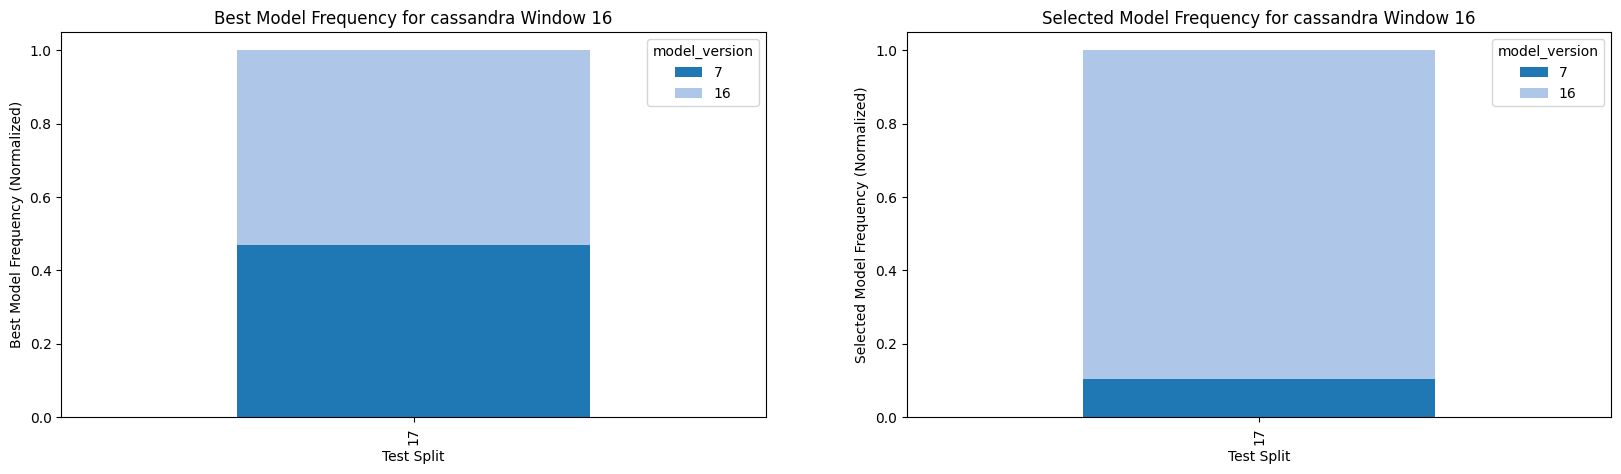

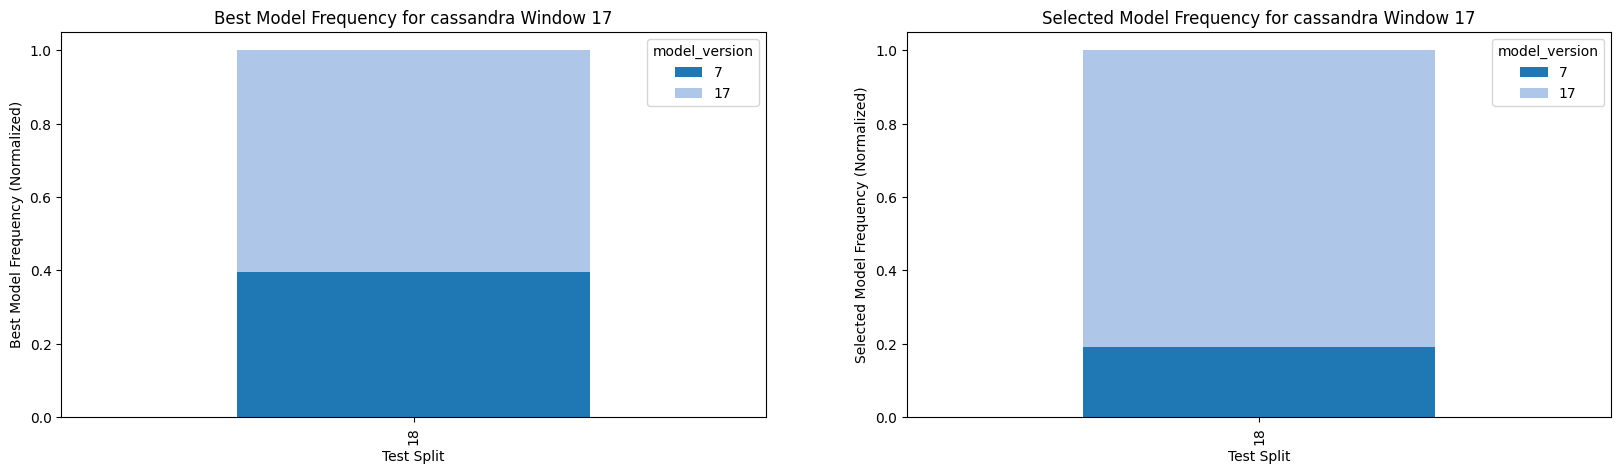

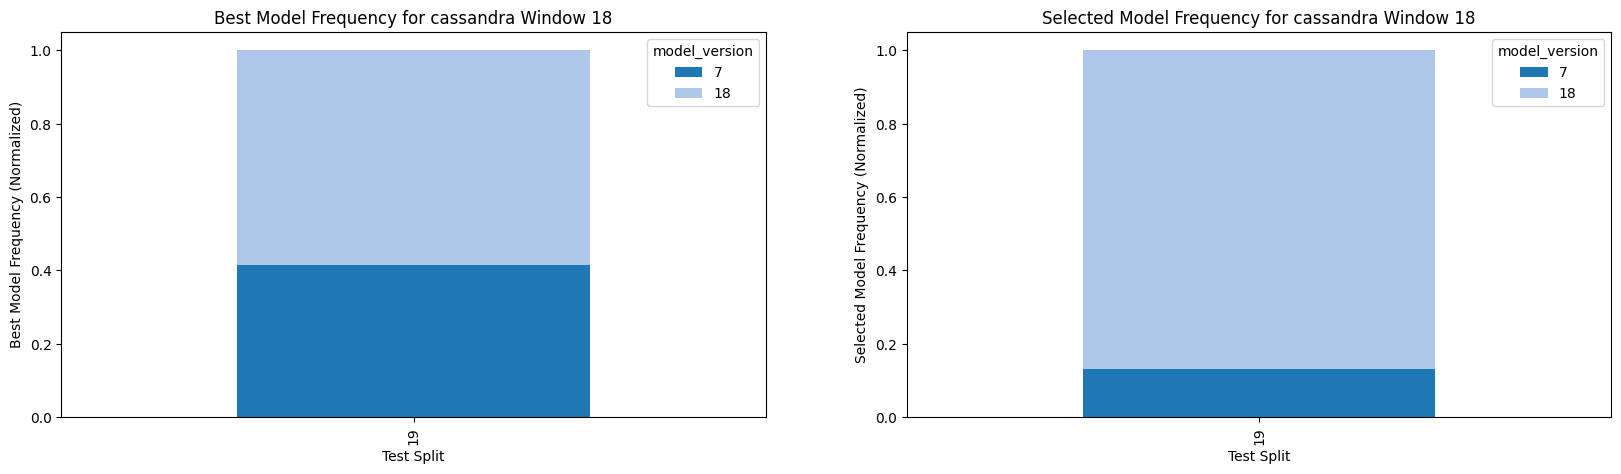

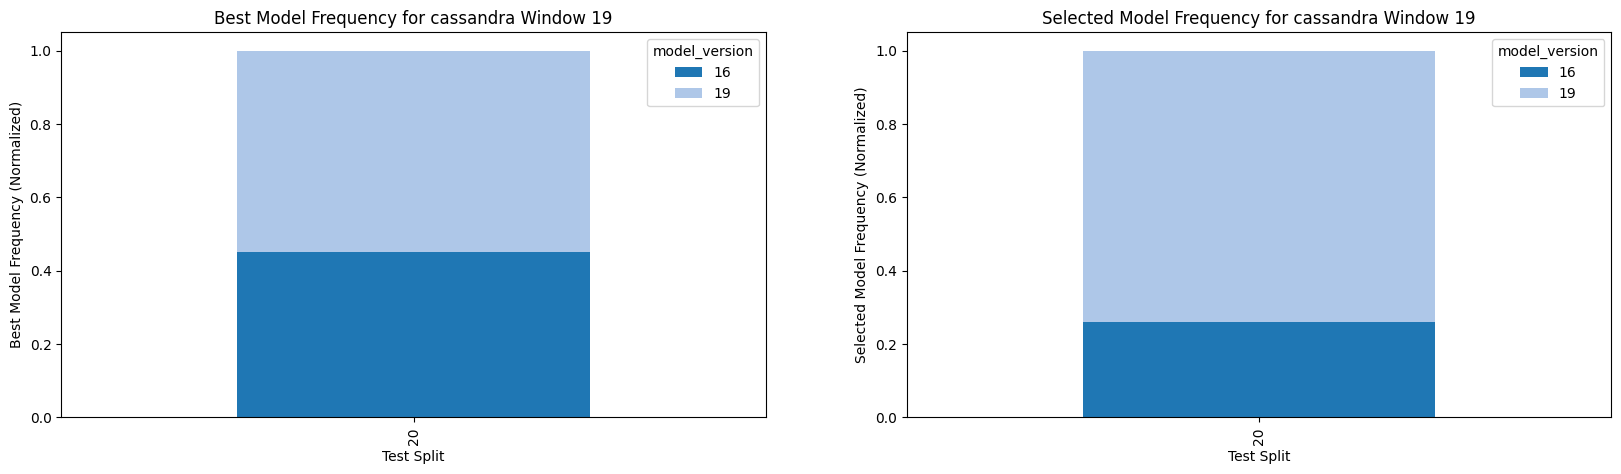

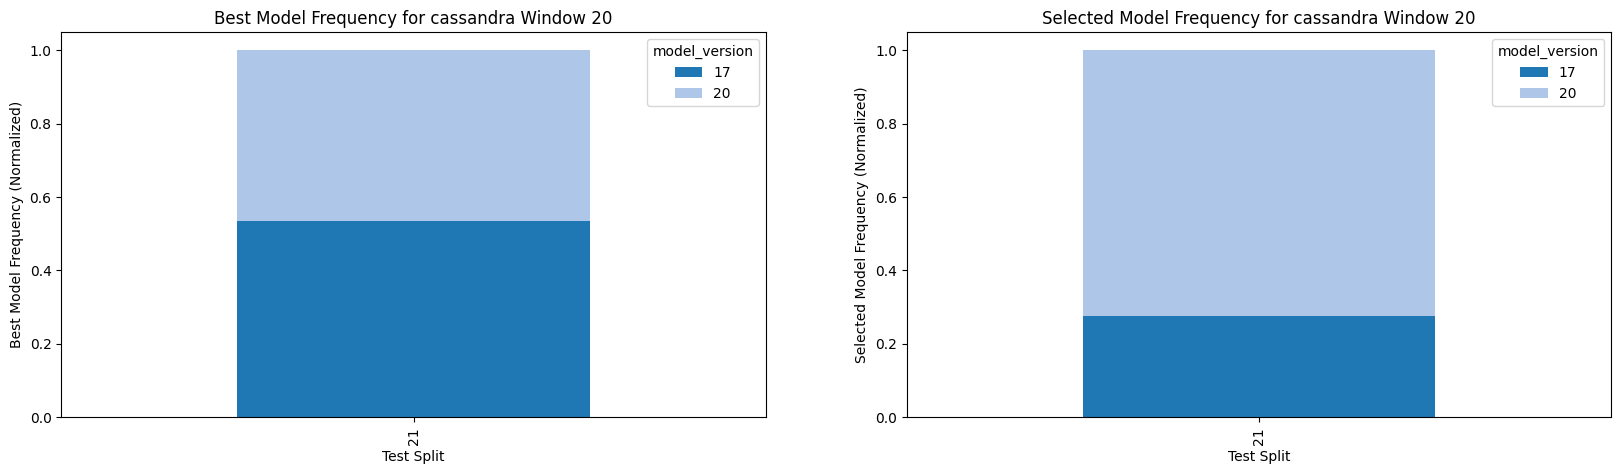

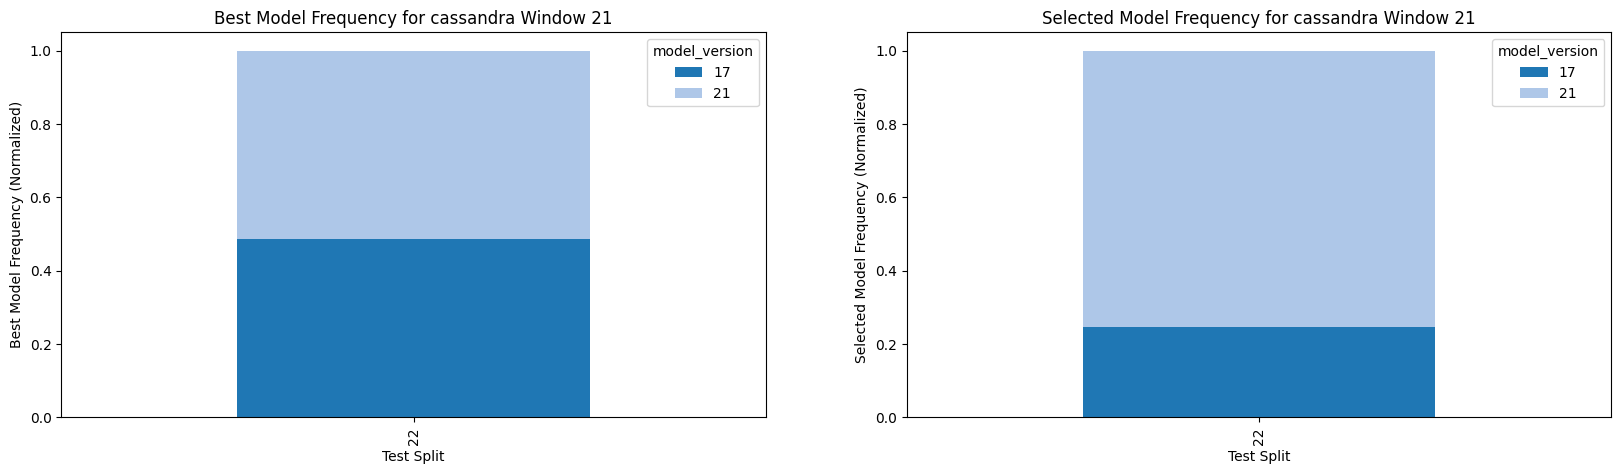

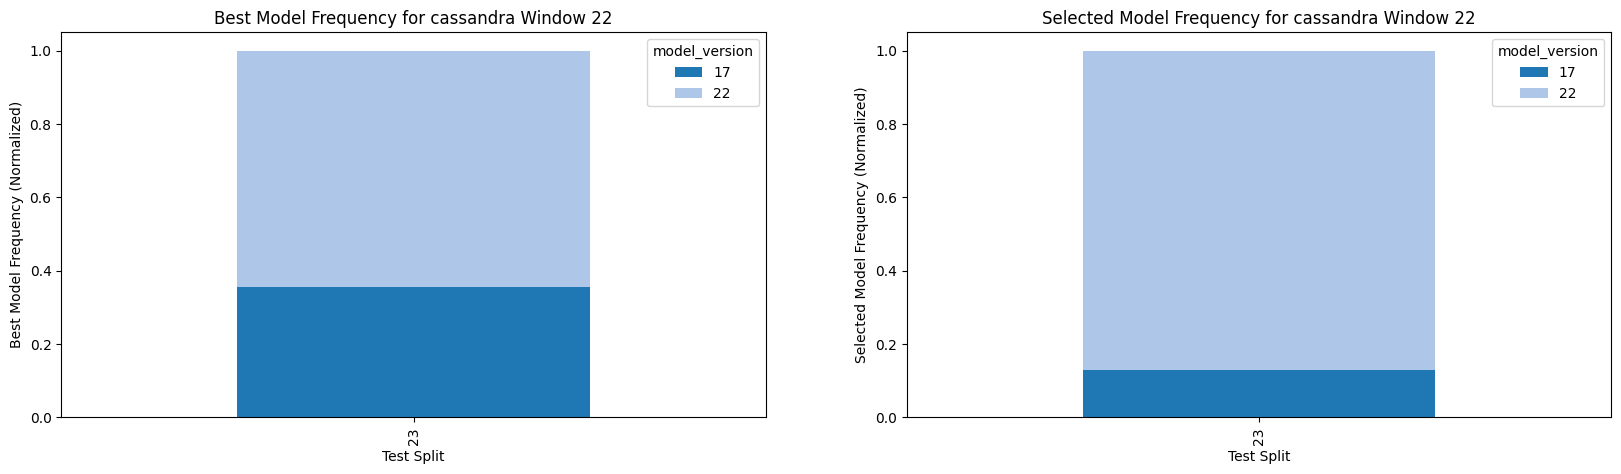

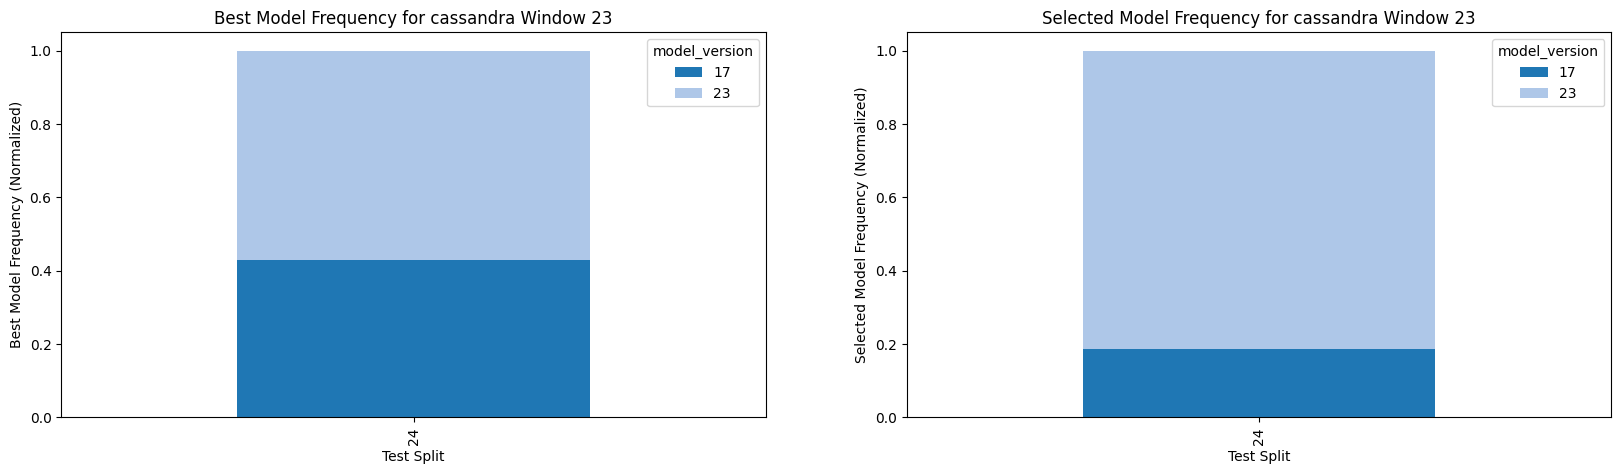

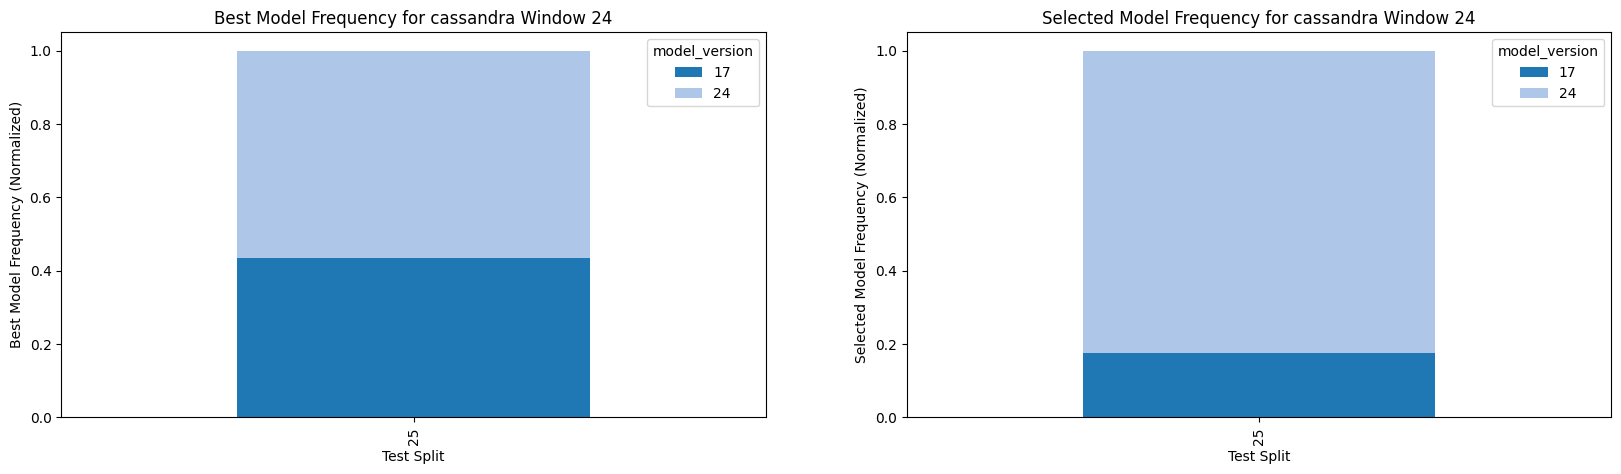

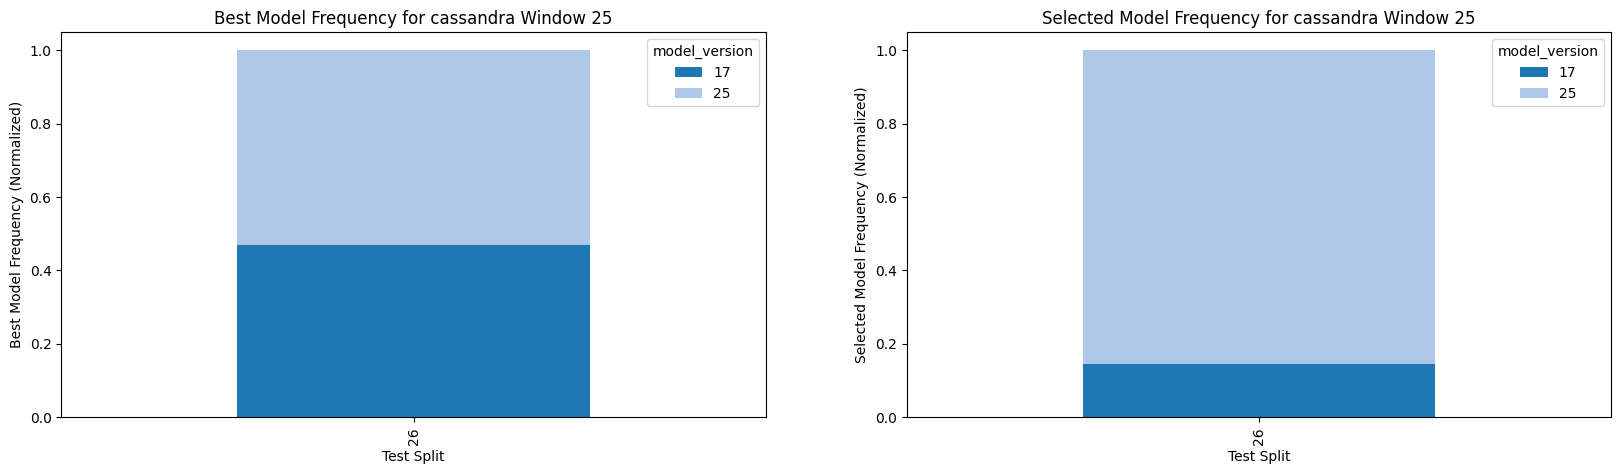

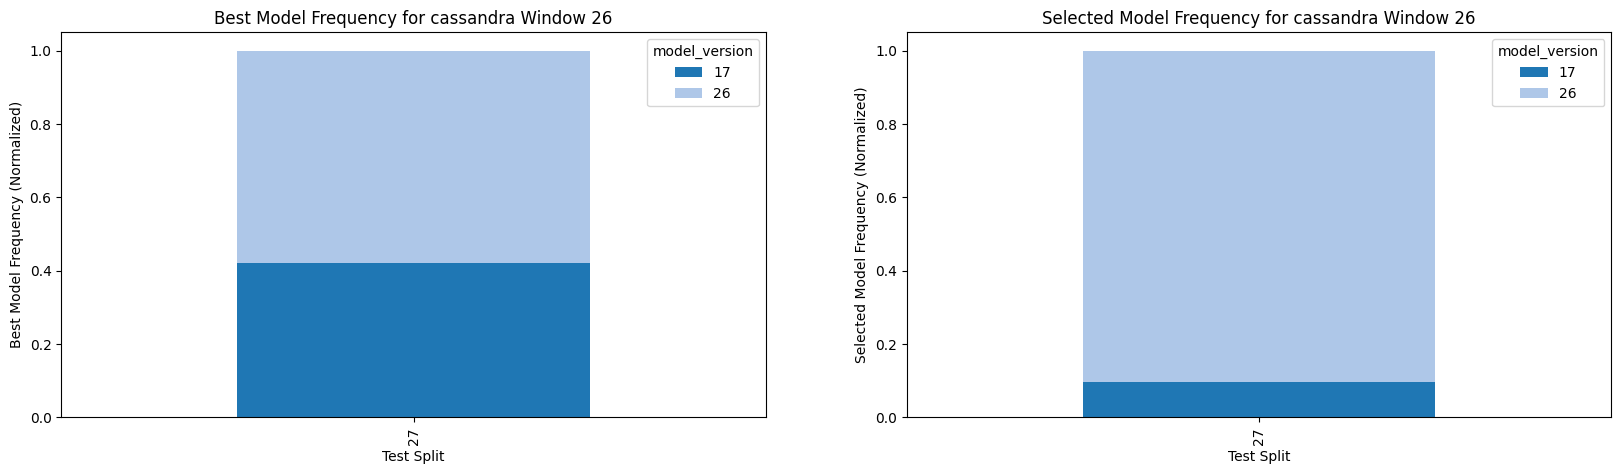

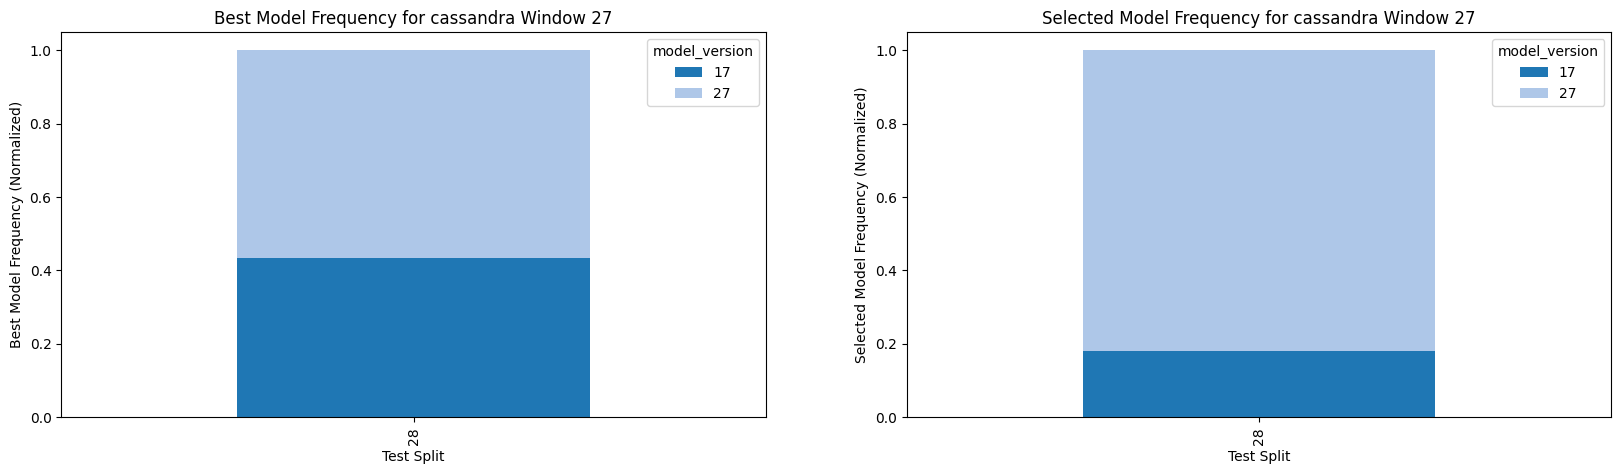

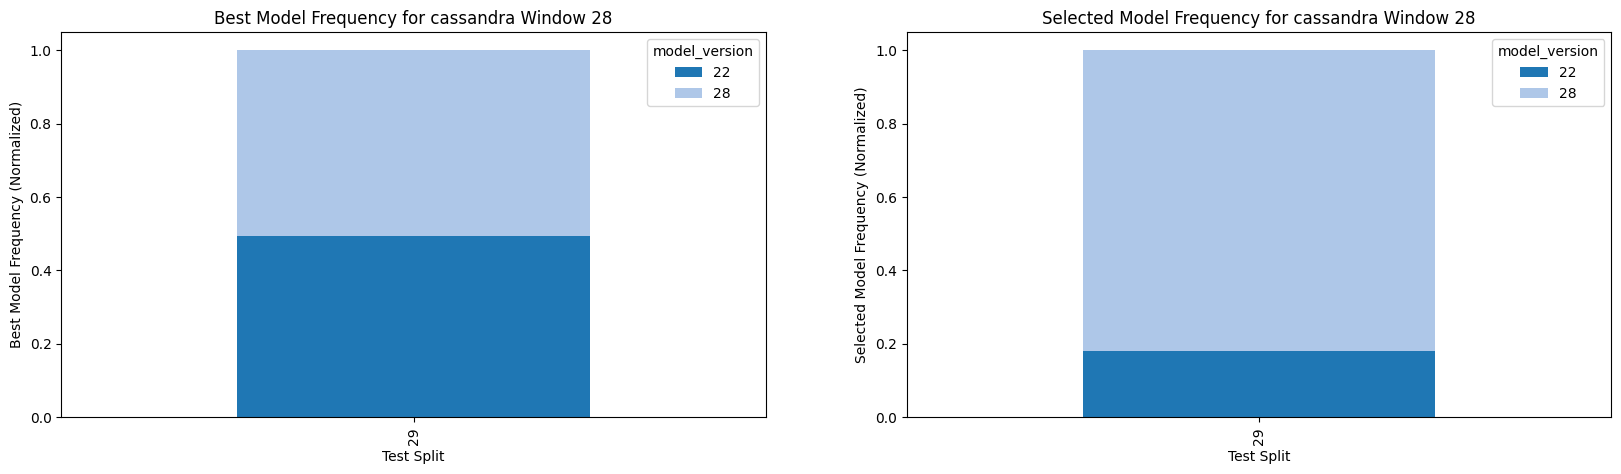

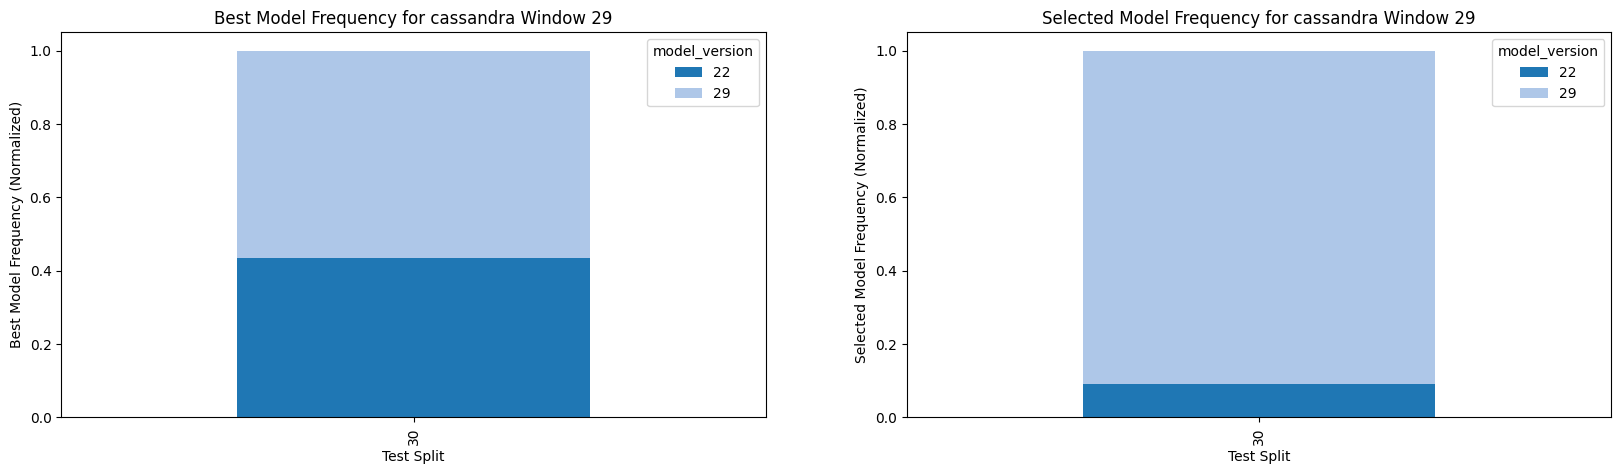

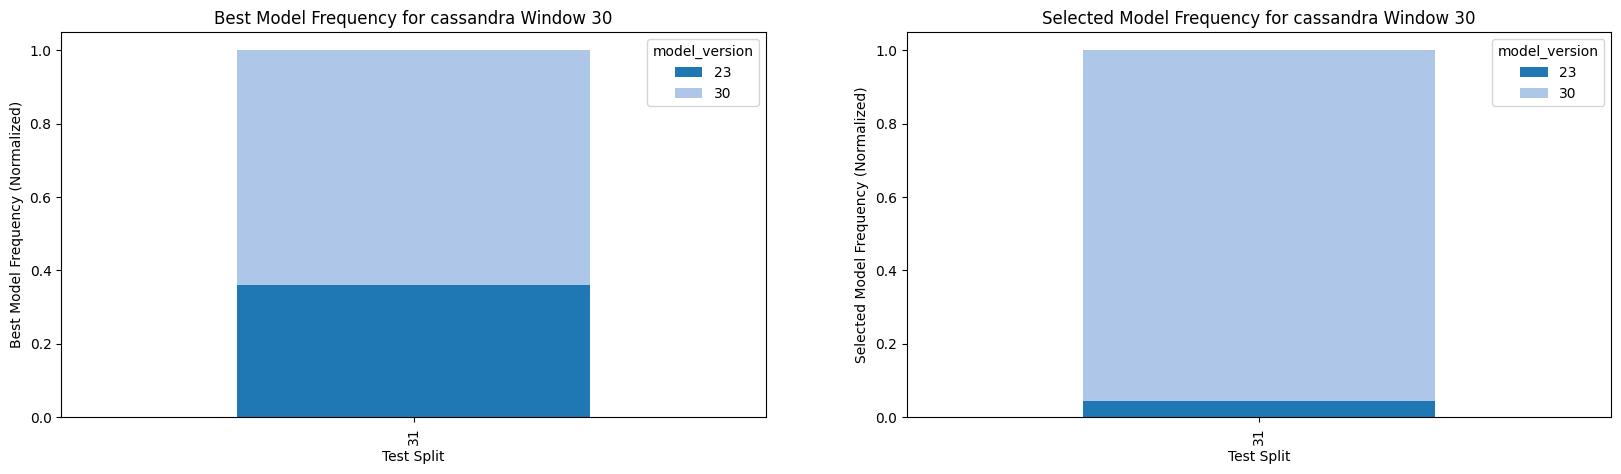

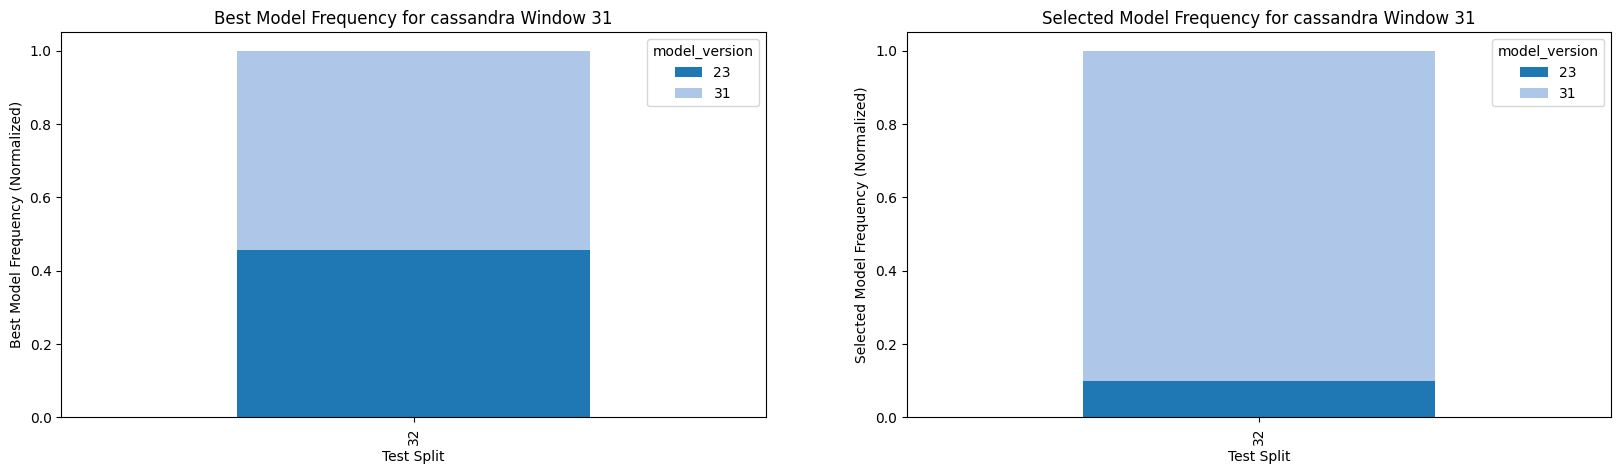

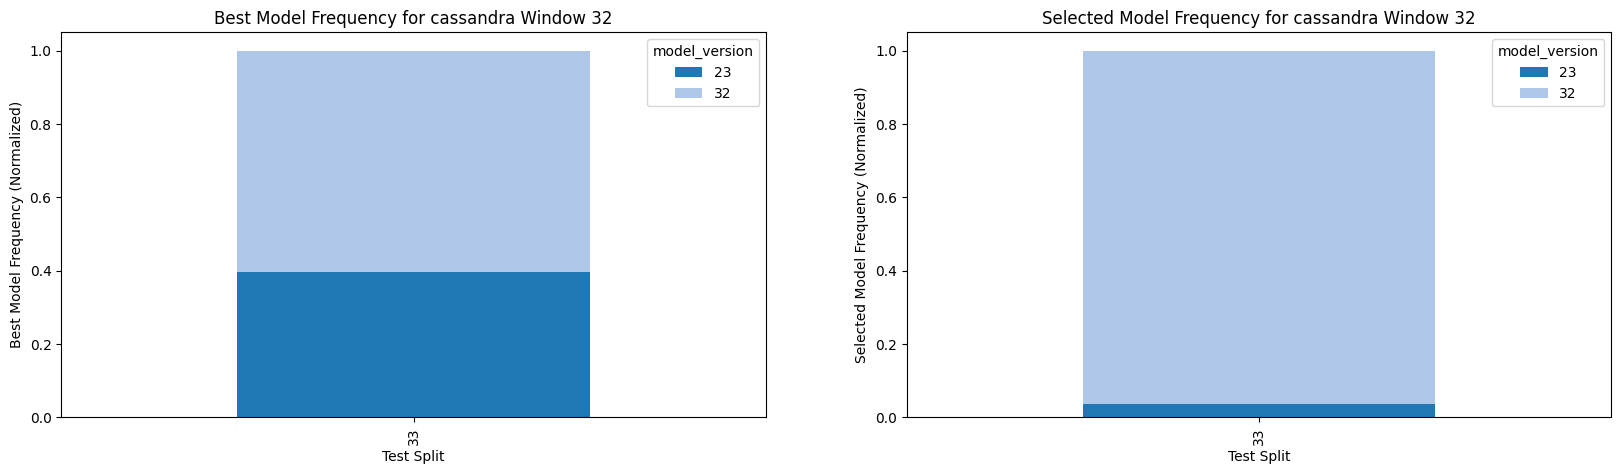

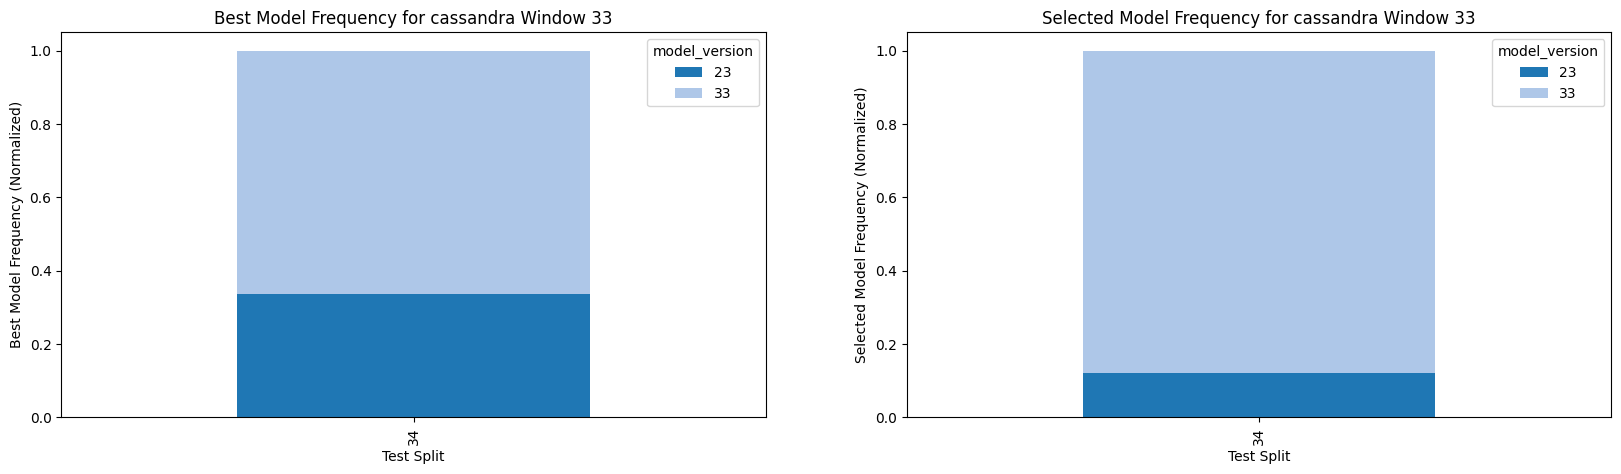

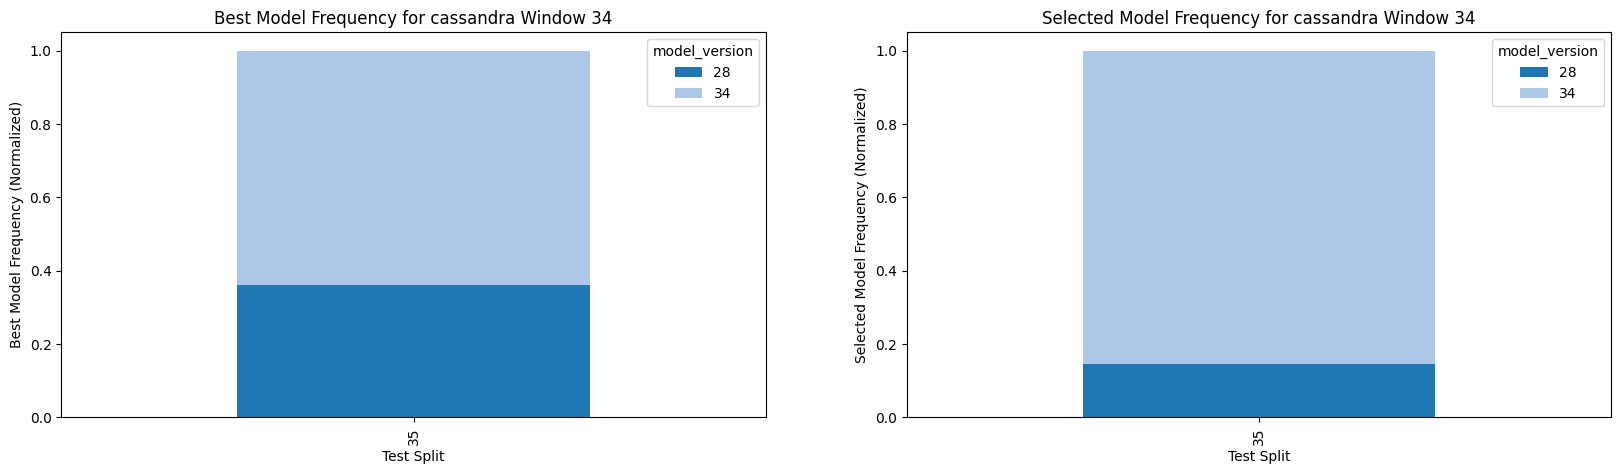

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_selektmodel_df = selektmodel_df[selektmodel_df["window"] == i]
    temp_selektmodel_df = temp_selektmodel_df[temp_selektmodel_df["test_split"] == i + 1]
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]
    # plot normalized best model frequency per test split side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    # find unique models
    unique_models = set(temp_bestmodel_df["model_version"].unique()) | set(temp_selektmodel_df["model_version"].unique())
    unique_models = list(unique_models)
    unique_models.sort()

    # creating color palette
    palette_colors = sns.color_palette('tab20')
    palette_dict = {model_version: color for model_version, color in zip(unique_models, palette_colors)}

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True, ax=ax1, color=palette_dict)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")
    
    # selected model
    model_frequency_by_test_split = temp_selektmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    q = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True, ax=ax2, color=palette_dict)
    q.set_xlabel("Test Split")
    q.set_ylabel("Selected Model Frequency (Normalized)")
    q.set_title(f"Selected Model Frequency for {PROJECT_NAME} Window {i}")
    plt.show()